In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/ML and Image/Sheet_music_reader_Project/Mask_RCNN')

In [0]:
# detect kangaroos in photos with mask rcnn model
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
import cv2
from google.colab.patches import cv2_imshow

In [0]:
# class that defines and loads the kangaroo dataset
class MusicDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "treble")
		self.add_class("dataset", 2, "bass")
		self.add_class("dataset", 3, "black note")
		self.add_class("dataset", 4, "white note")
		self.add_class("dataset", 5, "whole note")

		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00201']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 177 and int(image_id) <= 196:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 177 and int(image_id) > 196:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename, className = 'all'):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# print('tree : {}' .format(tree))
		# get the root of the document
		root = tree.getroot()

		boxes = list()
		# extract each bounding box
		for Object in root.findall('object'):
			Name = Object.find('name')
			# print(Name.text)
			#	can change interest box from this
			if Name.text != className and className != 'all':
				continue
			box = Object.find('bndbox')
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			#	add box and class name in list
			coors = [xmin, ymin, xmax, ymax, Name.text]
			boxes.append(coors)
		
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height
 
	# load the masks for an image
	def load_mask(self, image_id, className = 'all'):
		# get details of image
		info = self.image_info[image_id]
		# print('info : {}' .format(info))
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path, className)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			# if image_id == 4:
			# 	print('class_names : {}' .format(box[4]))
			class_ids.append(self.class_names.index(box[4]))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

In [0]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "musicdatasets_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 5
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [0]:
def classIdToClassName(classId):
  classNameList = ['treble', 'bass', 'blacknote', 'whitenote', 'wholenote']
  return classNameList[classId-1]

In [0]:
# plot a number of photos with ground truth and predictions
def musicdatasets_predicted(model, cfg, path):
	''' format of detectedDict
		{
			'treble' : [ [x1, y1, x2, y2], [x1, y1, x2, y2], ... ]
			'bass' : [ [x1, y1, x2, y2], [x1, y1, x2, y2], ... ]
			'blacknote' : [ [x1, y1, x2, y2], [x1, y1, x2, y2], ... ]
			'whitenote' : [ [x1, y1, x2, y2], [x1, y1, x2, y2], ... ]
			'wholenote' : [ [x1, y1, x2, y2], [x1, y1, x2, y2], ... ]
		}

		** Xcoor, Ycoor -> list()

		RETURN : detectedDict
	'''
	# load the image and mask
	image = cv2.imread(path)
	# convert pixel values (e.g. center)
	scaled_image = mold_image(image, cfg)
	# convert image into one sample
	sample = expand_dims(scaled_image, 0)
	# make prediction
	yhat = model.detect(sample, verbose=0)[0]
	detectedDict = { 'treble' : [], 'bass' : [], 'blacknote' : [], 'whitenote' : [], 'wholenote' : [] }

	for index in range( len(yhat['class_ids']) ):
		className = classIdToClassName( int(yhat['class_ids'][index]) )
		y1, x1, y2, x2 = yhat['rois'][index]
		# create the shape
		image = cv2.rectangle( image, (x1, y1), (x2, y2), (255, 0, 0), 2 )
		detectedDict[className].append( [x1, y1, x2, y2] )
	
	imageHeight = image.shape[0]
	imageWidth = image.shape[1]
	image = cv2.resize(image, ( int(imageWidth/3), int(imageHeight/3)) )
	cv2_imshow(image)

	return detectedDict

Train: 240
Test: 260


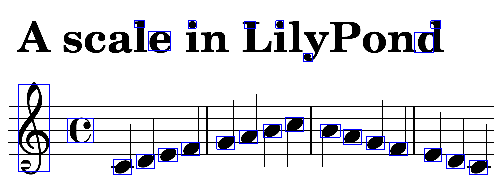

detectedDict :  {'treble': [[56, 253, 148, 514]], 'bass': [], 'blacknote': [[1029, 388, 1084, 433], [1338, 464, 1394, 504], [475, 444, 531, 484], [1408, 482, 1463, 522], [340, 479, 394, 522], [961, 372, 1020, 411], [790, 372, 845, 411], [408, 463, 462, 505], [1167, 426, 1221, 467], [1099, 408, 1153, 448], [544, 426, 598, 466], [1272, 446, 1325, 484], [856, 353, 911, 393], [650, 409, 703, 447], [717, 391, 773, 430], [734, 63, 767, 85], [201, 355, 279, 426], [827, 62, 851, 84], [445, 94, 512, 151], [403, 62, 433, 82], [1292, 62, 1322, 84], [565, 62, 588, 84], [910, 160, 937, 183], [1244, 96, 1301, 157]], 'whitenote': [], 'wholenote': []}


In [0]:
# load the train dataset
train_set = MusicDataset()
train_set.load_dataset('datasets', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = MusicDataset()
test_set.load_dataset('datasets', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_musicdatasets_cfg_0050.h5'
model.load_weights(model_path, by_name=True)

imageFile = '00002.png'

# plot predictions for train dataset
detectedDict = musicdatasets_predicted(model, cfg, path = imageFile)
print('detectedDict : ', detectedDict)

In [0]:
with open("music_notation_location.txt", "w") as f:
    f.write('{}\n' .format(imageFile))
    f.write(str(detectedDict))